In [ ]:
# initial LSTM model code

# doesn't contain ckpt and data, will be automatically loaded during runtime
# this is our first attempt for using LSTM, the results are ~50%, which
# led to us considering adding input/output filters to the model to increase
# the accuracy and effectiveness of the model, leading to CLAM later on...

/tmp/ipython-input-1786068784.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


→ Saved daily data to aapl_daily_2018-2025.csv (2018-01-01→2025-06-30)
Epoch 01  Train MSE=0.001319  Val MSE=0.000627
Epoch 02  Train MSE=0.000582  Val MSE=0.000493
Epoch 03  Train MSE=0.000468  Val MSE=0.000478
Epoch 04  Train MSE=0.000492  Val MSE=0.000475
Epoch 05  Train MSE=0.000444  Val MSE=0.000470
Epoch 06  Train MSE=0.000430  Val MSE=0.000418
Epoch 07  Train MSE=0.000430  Val MSE=0.000449
Epoch 08  Train MSE=0.000435  Val MSE=0.000419
Epoch 09  Train MSE=0.000438  Val MSE=0.000419
Epoch 10  Train MSE=0.000413  Val MSE=0.000457
Epoch 11  Train MSE=0.000414  Val MSE=0.000441
Early stopping at epoch 11
Direction Accuracy: 0.533
              precision    recall  f1-score   support

        Down      0.496     0.812     0.616        85
          Up      0.644     0.293     0.403        99

    accuracy                          0.533       184
   macro avg      0.570     0.552     0.509       184
weighted avg      0.576     0.533     0.501       184



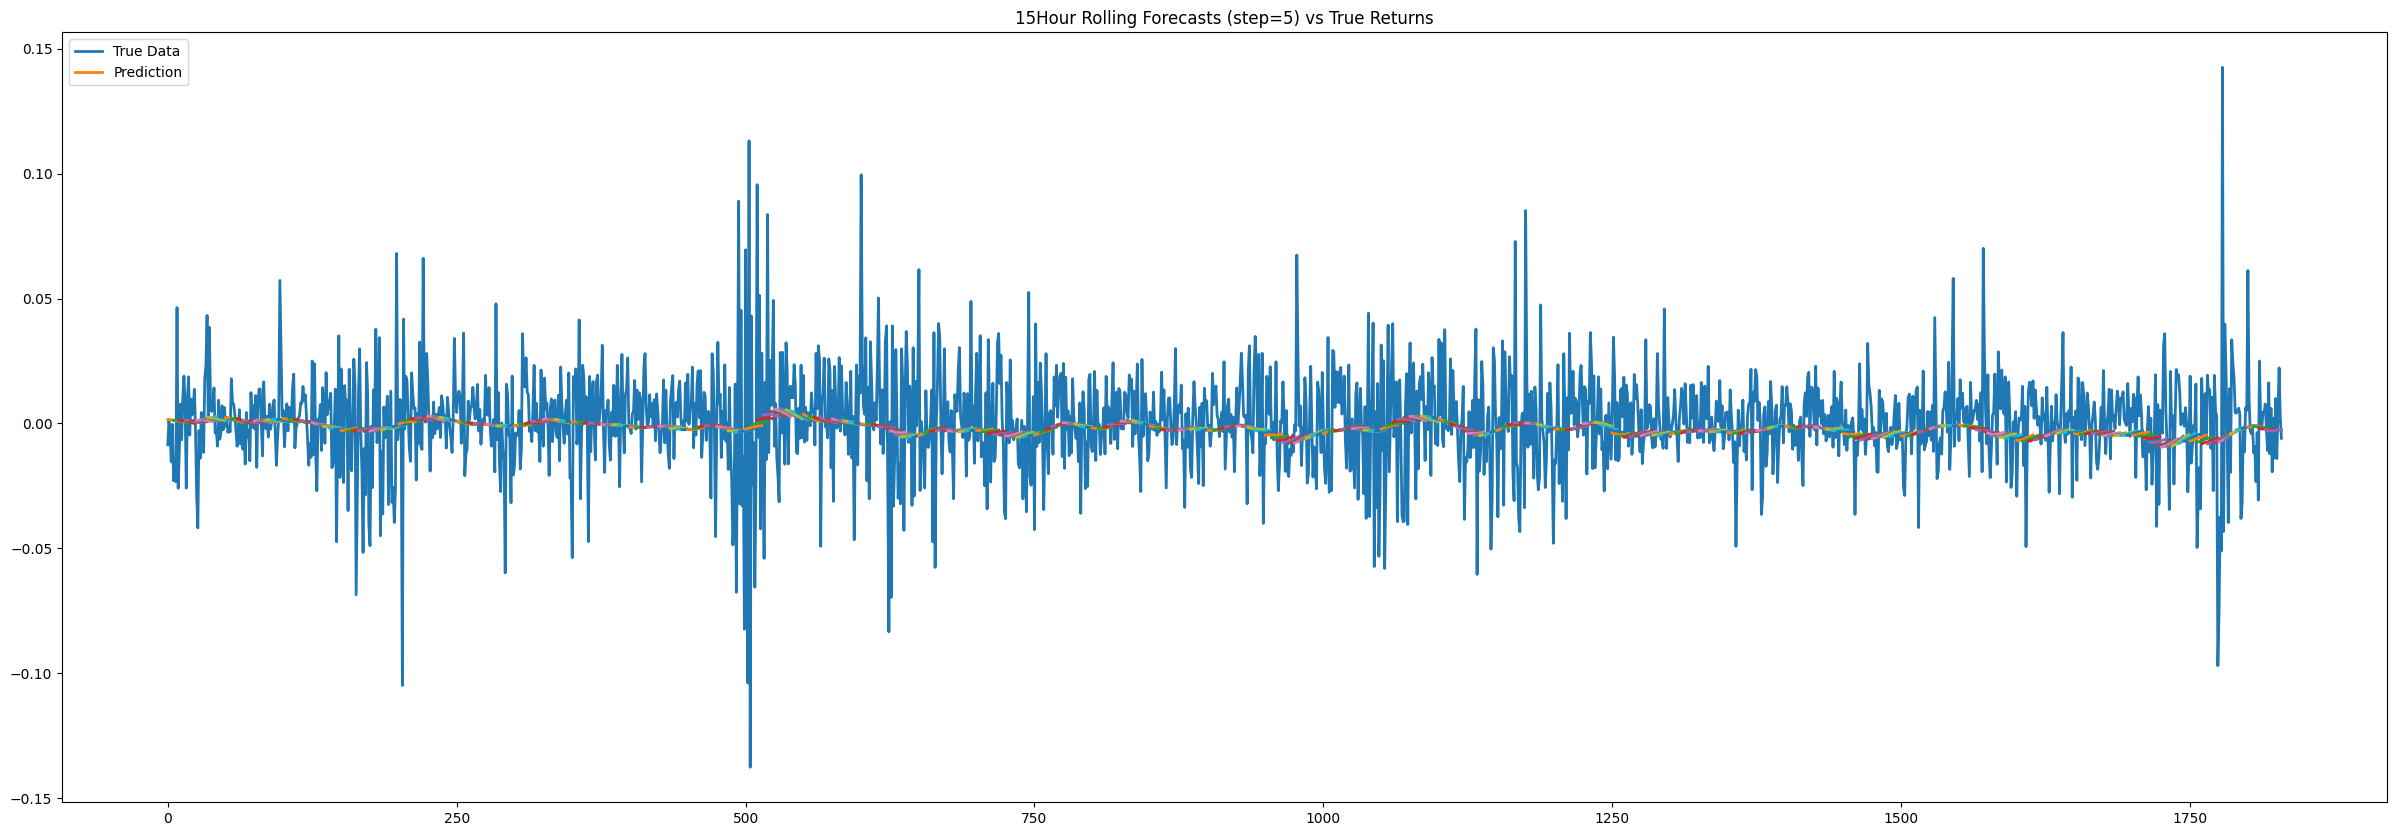

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


TICKER       = "AAPL"
START_DATE   = "2018-01-01"
END_DATE     = "2025-06-30"
INTERVAL     = "1d"
SEQ_LEN      = 30
BATCH        = 64
LR           = 1e-3
WEIGHT_DECAY = 1e-5
PATIENCE     = 5
N_EPOCHS     = 50

df = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL
)
df.to_csv("aapl_daily_2018-2025.csv")
print(f"→ Saved daily data to aapl_daily_2018-2025.csv ({START_DATE}→{END_DATE})")

for w in (5,10,20):
    df[f"MA_{w}"] = df["Close"].rolling(w).mean()

def compute_rsi(s, window=14):
    d  = s.diff()
    up =  d.clip(lower=0).rolling(window).mean()
    dn = -d.clip(upper=0).rolling(window).mean()
    rs = up/dn
    return 100 - 100/(1+rs)
df["RSI_14"] = compute_rsi(df["Close"],14)

ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"]     = ema12 - ema26
df["MACD_SIG"] = df["MACD"].ewm(span=9, adjust=False).mean()

bbm = df["Close"].rolling(20).mean()
bbs = df["Close"].rolling(20).std()
df["BB_upper"] = bbm + 2*bbs
df["BB_lower"] = bbm - 2*bbs

delta = df["Close"].diff()
sign  = np.sign(delta).fillna(0)
df["OBV"]     = (sign * df["Volume"]).cumsum()

df["dow_sin"]     = np.sin(2*np.pi*df.index.dayofweek/7)
df["dow_cos"]     = np.cos(2*np.pi*df.index.dayofweek/7)
df["mon_sin"]     = np.sin(2*np.pi*df.index.month/12)
df["mon_cos"]     = np.cos(2*np.pi*df.index.month/12)
df["is_month_end"]= df.index.is_month_end.astype(int)

df["log_ret"] = np.log(df["Close"]/df["Close"].shift(1))
df.dropna(inplace=True)

ts_all = df.index

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_5","MA_10","MA_20",
    "RSI_14","MACD","MACD_SIG",
    "BB_upper","BB_lower","OBV",
    "dow_sin","dow_cos","mon_sin","mon_cos","is_month_end"
]

X_all = df[FEATURES].values
y_all = df["log_ret"].values.reshape(-1,1)

scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

X_win, y_win, ts_win = [], [], []
for i in range(len(X_all) - SEQ_LEN):
    X_win.append(X_all[i : i + SEQ_LEN])
    y_win.append(y_all[i + SEQ_LEN][0])
    ts_win.append(ts_all[i + SEQ_LEN])
X_win   = np.stack(X_win)
y_win   = np.array(y_win)
ts_win  = np.array(ts_win)

X_tr, X_tmp, y_tr, y_tmp, ts_tr, ts_tmp = train_test_split(
    X_win, y_win, ts_win, test_size=0.2, shuffle=True, random_state=42
)
X_val, X_te, y_val, y_te, ts_val, ts_te = train_test_split(
    X_tmp, y_tmp, ts_tmp, test_size=0.5, shuffle=True, random_state=42
)

class TSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(TSDataset(X_tr, y_tr), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(TSDataset(X_val, y_val), batch_size=BATCH)
test_loader  = DataLoader(TSDataset(X_te,  y_te),  batch_size=BATCH)

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim, 1)
    def forward(self, H):
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)
        return torch.bmm(w.unsqueeze(1), H).squeeze(1)

class BiAttnLSTMReg(nn.Module):
    def __init__(self, in_dim, hid_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)
        self.attn = Attention(hid_dim*2)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(hid_dim*2, 1)
    def forward(self, x):
        H, _ = self.lstm(x)
        c    = self.attn(H)
        return self.fc(self.drop(c))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = BiAttnLSTMReg(in_dim=X_win.shape[2]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total = 0
    with torch.set_grad_enabled(train):
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if train: optimizer.zero_grad()
            out = model(Xb)
            loss= criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)

best_val, wait = float('inf'), 0
for ep in range(1, N_EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader,   True)
    scheduler.step(va)
    print(f"Epoch {ep:02d}  Train MSE={tr:.6f}  Val MSE={va:.6f}")
    if va < best_val:
        best_val, wait = va, 0
        torch.save(model.state_dict(), "best_model_reg.pth")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {ep}")
            break

model.load_state_dict(torch.load("best_model_reg.pth"))

model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_te, dtype=torch.float32).to(device)) \
               .cpu().numpy().flatten()


pred_dir = (preds > 0).astype(int)
true_dir = (y_te.flatten() > 0).astype(int)

acc = accuracy_score(true_dir, pred_dir)
print(f"Direction Accuracy: {acc:.3f}")
print(classification_report(true_dir, pred_dir,
      target_names=["Down","Up"], digits=3))

def create_windows(X, win):
    return np.stack([X[i:i+win] for i in range(len(X)-win+1)])

def forecast_many(model, X_win, horizon, step):
    model.eval()
    chunks = []
    with torch.no_grad():
        for start in range(0, len(X_win) - horizon, step):
            seq = X_win[start].copy()
            ps  = []
            for _ in range(horizon):
                out = model(torch.tensor(seq[None], dtype=torch.float32)
                            .to(device)).item()
                ps.append(out)
                seq = np.vstack([seq[1:], np.zeros(seq.shape[1])])
            chunks.append(ps)
    return np.array(chunks)

def plot_results_multiple(pred_chunks, true_series, h):
    plt.figure(figsize=(30,10))
    plt.plot(true_series, label="True Data", linewidth=2)
    for i, chunk in enumerate(pred_chunks):
        start, end = i*STEP, i*STEP + h
        plt.plot(np.arange(start, end), chunk,
                 linewidth=2,
                 label="Prediction" if i==0 else None)
    plt.legend(loc="upper left")
    plt.title(f"{h}Hour Rolling Forecasts (step={STEP}) vs True Returns")
    plt.show()

HORIZON = 15
STEP = 5

X_flat   = scaler.transform(df[FEATURES].values)
test_win = create_windows(X_flat, SEQ_LEN)
pred_chunks = forecast_many(model, test_win, HORIZON, STEP)
true_slice = y_all[SEQ_LEN : SEQ_LEN + len(pred_chunks)*STEP + (HORIZON-STEP)]
plot_results_multiple(pred_chunks, true_slice, HORIZON)